In [1]:
!pip install gymnasium[all] opencv-python matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━

In [33]:
from IPython.display import clear_output


In [2]:
import torch
import time
import cv2
import matplotlib as plt
import  gymnasium as gym
from Gridworld_Game import Gridworld
import numpy as np
import random

In [4]:
Grid_size = 4
game = Gridworld(Grid_size=Grid_size, mode="static")

In [5]:
action = game.actions_space.sample()

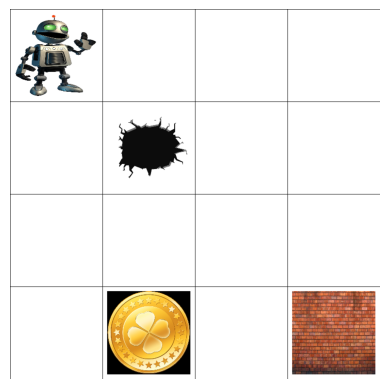

In [6]:
game.reset()
game.render(mode="human")
time.sleep(20)
game.close()

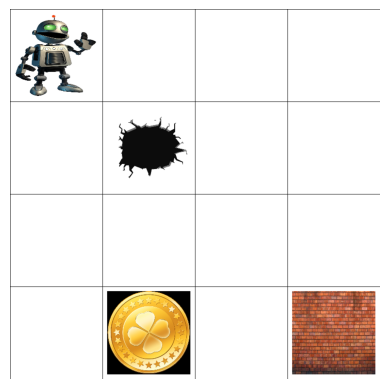

In [7]:
game.step(action)
game.render(mode="human")
time.sleep(20)
game.close()

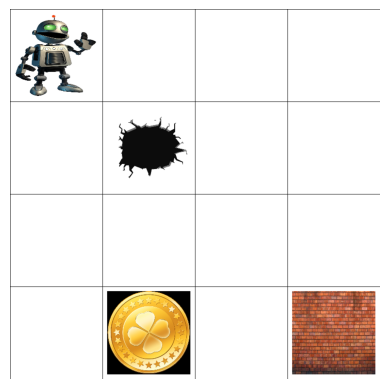

In [8]:
game.step(action)
game.render(mode="human")
time.sleep(5)
game.close()

In [9]:
actions = {"left":0, "right":1, "up":2, "down":3}

In [10]:
game.step(actions["left"])

(array([[[1, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 1, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 0, 0, 1],
         [0, 0, 0, 0],
         [0, 0, 1, 0]]], dtype=int32),
 -1,
 False,
 {'items': {'Agent': 0, 'Hole': 1, 'Wall': 2, 'Goal': 3},
  'Grid_size': 4,
  'actions': ['Left', 'Right', 'Up', 'Down']})

In [11]:
class Net(torch.nn.Module):
    def __init__(self, input_shape, output_shape):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(input_shape, 150)
        self.linear2 = torch.nn.Linear(150, 100)
        self.linear3 = torch.nn.Linear(100, output_shape)
        self.activation = torch.nn.ReLU()
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        return x


In [12]:
def preprocess_state(state, input_shape, add_noise = False):
    if add_noise == True:
        state = state.reshape(*input_shape) + np.random.rand(*input_shape)/10.0
    else:
        state = state.reshape(input_shape)
    return state

In [23]:
def get_action(Q_values, num_actions, epsilon):
    if (random.random() < epsilon):
        action = np.random.randint(0,4)
    else:
        action = np.argmax(Q_values, 1)[0]
    return action


In [30]:
class target_maker:
    def __init__(self, terminal_rewards):
        self.terminal_rewards = terminal_rewards

    def __call__(self, current_reward, gamma, maxQ):
        if current_reward not in self.terminal_rewards:
            target_value = current_reward + (gamma * maxQ)
        else:
            target_value = current_reward
        return torch.tensor([target_value], dtype=torch.float32).detach()



In [31]:
input_shape = Grid_size**3
output_shape = len(actions)
Agent = Net(input_shape, output_shape)

In [26]:
state1 = game.state
state1 = preprocess_state(state1, (1, input_shape), add_noise=True)
state1 = torch.from_numpy(state1).float()

In [27]:
Q_val = Agent(state1)
Q_val_numpy = Q_val.detach().numpy()

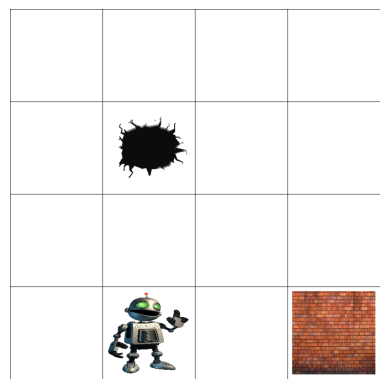

2999 0.19714383780956268


In [34]:
epochs = 3000
losses = []
gamma = 0.9
learning_rate = 0.001
optimizer = torch.optim.Adam(Agent.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()
create_target = target_maker([-10,+10])
epsilon = 1.0

for i in range(epochs):
    game = Gridworld(Grid_size=4,mode='static',frame_size=(800,800,3)) #C
    game.reset()
    state1 = game.state
    state1 = preprocess_state(state1 ,(1,input_shape) ,add_noise = True)
    state1 = torch.from_numpy(state1).float()
    status = 1
    while(status == 1):
        qval = Agent(state1)
        qval_ = qval.data.detach().numpy()
        action = get_action(qval_ , 4 ,epsilon)
        state2 ,reward ,done ,_ = game.step(action)
        state2 = preprocess_state(state2 ,(1,input_shape) ,add_noise = True)
        state2 = torch.from_numpy(state2).float()

        with torch.no_grad():
            newQ = Agent(state2)
        maxQ = torch.max(newQ)
        game.render()
        Y = create_target(reward ,gamma ,maxQ)
        X = qval.squeeze()[action].unsqueeze(0)

        loss = loss_fn(X, Y)
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2

        if done == True:
            status = 0

    if epsilon > 0.1:
        epsilon -= (1/epochs)

In [ ]:
def get_batch(replay, batch_size, device = "cuda"):
    minibatch = random.sample(replay, batch_size)
    state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]).to(device)
    action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch]).long().to(device)
    reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch]).to(device)
    state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch]).to(device)
    done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch]).to(device)
    return state1_batch, action_batch, reward_batch, state2_batch, done_batch

In [ ]:
def batch_target(reward, gamma, maxQ, done_batch):
    Y = reward + (gamma * maxQ * (1 - done_batch))
    return Y


In [ ]:
def reward_metric(all_rewards_list, last_n_rewards = 20):
    if len(all_rewards_list) >= last_n_rewards:
        mean_reward = np.mean(all_rewards_list[-last_n_rewards:])
    else:
        mean_reward = 0
    return mean_reward

In [ ]:
def update(loss, optimizer):
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
from collections import deque
memory_size = 5000
batch_size = 200
replay = deque(maxlen=memory_size)
gamma = 0.9
learning_rate = 0.001
epochs = 10000
device="cuda"
losses = []
Agent = Net(input_shape ,output_shape).to(device)
optimizer = torch.optim.Adam(Agent.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()
epsilon = 1.0

all_rewards_list = []
mean_rewards = []

for i in range(epochs):
    game = Gridworld(Grid_size=4,mode='random',frame_size=(800,800,3))
    game.reset()
    state1 = game.state
    state1 = preprocess_state(state1 ,(1,input_shape) ,add_noise = False)
    state1 = torch.from_numpy(state1).float().to(device)
    status = 1
    mov = 0
    while(status == 1):
        mov += 1
        qval = Agent(state1)
        qval_ = qval.data.detach().cpu().numpy()

        action = get_action(qval_ , 4,epsilon)
        state2 ,reward ,done ,_ = game.step(action)

        state2 = preprocess_state(state2 ,(1,input_shape) ,add_noise = False)
        state2 = torch.from_numpy(state2).float().to(device)
        exp =  (state1, action, reward, state2, done)
        replay.append(exp)
        game.render()
        if len(replay) > batch_size:
            state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch = get_batch(replay ,batch_size ,device)
            Q1 = Agent(state1_batch)
            with torch.no_grad():
                Q2 = Agent(state2_batch)
            maxQ = torch.max(Q2 ,axis = 1)[0]
            Y = batch_target(reward_batch ,gamma ,maxQ ,done_batch)
            X = Q1.gather(dim=1,index=action_batch.unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y)
            print(i ,loss.item())
            clear_output(wait=True)
            losses.append(loss.item())
            update(loss ,optimizer)

            all_rewards_list.append(reward)
            mean_reward = reward_metric(all_rewards_list , 100)
            mean_rewards.append(mean_reward)

        state1 = state2
        if done == True or mov > max_moves:
            status = 0
            mov = 0
    if epsilon > 0.1:
        epsilon -= (1/epochs)

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.xlabel("steps",fontsize=22)
plt.ylabel("rewards",fontsize=22)

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [ ]:
episodes = 10
max_mov = 10
for i in range(episodes):
    game = Gridworld(Grid_size=Grid_size,mode='random')
    state1 = game.state
    state1 = preprocess_state(state1,(1 ,input_shape) ,add_noise=True)
    state1 = torch.from_numpy(state1).float().to(device)
    gate = 1
    mov = 0
    while(gate == 1):
        mov += 1
        Q_val = Agent(state1)
        Q_val_numpy = Q_val.detach().cpu().numpy()
        action = action = np.argmax(Q_val_numpy ,1)[0]
        state2 , reward ,done ,_ = game.step(action)
        state2 = preprocess_state(state2,(1 ,input_shape) ,add_noise=True)
        state2 = torch.from_numpy(state2).float().to(device)
        game.render()
        time.sleep(0.1)
        if done == True or mov == max_mov:
            gate = 0
        state1 = state2
    game.close()

In [ ]:
from collections import deque
import copy

memory_size = 5000
batch_size = 200
replay = deque(maxlen=memory_size)
gamma = 0.9
learning_rate = 0.001
epochs = 10000
sync_freq = 500
k = 0
device="cuda"
losses = []
Agent_NN = Net(input_shape ,output_shape).to(device)
target_NN = copy.deepcopy(Agent_NN)
target_NN.load_state_dict(Agent_NN.state_dict())


optimizer = torch.optim.Adam(Agent_NN.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()
epsilon = 1.0

all_rewards_list = []
mean_rewards = []

for i in range(epochs):
    game = Gridworld(Grid_size=4,mode='random',frame_size=(800,800,3))
    game.reset()
    state1 = game.state
    state1 = preprocess_state(state1 ,(1,input_shape) ,add_noise = True)
    state1 = torch.from_numpy(state1).float().to(device)
    status = 1
    while(status == 1):
        k = k + 1
        qval = Agent_NN(state1)
        qval_ = qval.data.detach().cpu().numpy()

        action = get_action(qval_ , 4,epsilon)
        state2 ,reward ,done ,_ = game.step(action)

        state2 = preprocess_state(state2 ,(1,input_shape) ,add_noise = True)
        state2 = torch.from_numpy(state2).float().to(device)
        exp =  (state1, action, reward, state2, done)
        replay.append(exp)
        game.render()
        if len(replay) > batch_size:
            state1_batch ,action_batch ,reward_batch ,state2_batch ,done_batch = get_batch(replay ,batch_size ,device)
            Q1 = Agent_NN(state1_batch)
            with torch.no_grad():
                Q2 = target_NN(state2_batch)
            maxQ = torch.max(Q2 ,axis = 1)[0]
            Y = batch_target(reward_batch ,gamma ,maxQ ,done_batch)
            X = Q1.gather(dim=1,index=action_batch.unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y)
            print(i ,loss.item())
            clear_output(wait=True)
            losses.append(loss.item())
            update(loss ,optimizer)

            all_rewards_list.append(reward)
            mean_reward = reward_metric(all_rewards_list , 100)
            mean_rewards.append(mean_reward)

        state1 = state2

        if k % sync_freq == 0:
            target_NN.load_state_dict(Agent_NN.state_dict())

        if done == True:
            status = 0

    if epsilon > 0.1:
        epsilon -= (1/epochs)

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(mean_rewards)
plt.xlabel("steps",fontsize=22)
plt.ylabel("rewards",fontsize=22)

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [ ]:
while(os.getcwd().split('\\')[-1] != "RL"):
      os.chdir(os.path.dirname(os.getcwd()))